<a href="https://colab.research.google.com/github/NgoranA/TP1-INF4248-CNN/blob/main/TP1_INF4248_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ngoran aristide

In [2]:
pip install torch torchvision opencv-contrib-python scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

Here we want to create our own version of the LeNet Architecture.

In [3]:
# import the necessary packages
from torch.nn import Module # this is in order to see how pytorch implements neural networks with classes.
from torch.nn import Conv2d # This is pytorch's implementation of convolutional layers
from torch.nn import Linear # FC layers
from torch.nn import MaxPool2d # Applies 2D max-pooling to reduce the spatial dimensions of the input volume
from torch.nn import ReLU
from torch.nn import LogSoftmax # helps return probabilistic predictions of each class
from torch import flatten

Here, we are setting up the architecture for the LeNet model, including **convolutional**, **activation**, **pooling**, and **fully connected layers**, as well as a **softmax classifier** for classifying input images into different classes.

In [4]:
class LeNet(Module):
    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(LeNet, self).__init__()

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=800, out_features=500)
        self.relu3 = ReLU()

        # initialize our softmax classifier
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self, x):
        # pass the input through our first set of CONV => RELU => POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)

        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)

        # return the output predictions
        return output


In [11]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("module://ipykernel.pylab.backend_inline")
# import the necessary packages
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

In [6]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-m", "--model", type=str, required=True, help="path to output trained model")
# ap.add_argument("-p", "--plot", type=str, required=True, help="path to output loss/accuracy plot")
# args = vars(ap.parse_args(["--model", "path_to_model", "--plot", "path_to_plot"]))

In [7]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# load the KMNIST dataset
trainData = KMNIST(root="data", train=True, download=True, transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())

# calculate the train/validation split
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData, [numTrainSamples, numValSamples], generator=torch.Generator().manual_seed(42))

100%|██████████| 18165135/18165135 [00:07<00:00, 2464479.10it/s]


Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 450286.56it/s]


Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:01<00:00, 1559184.38it/s]


Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 20374607.67it/s]

Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw



In [9]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)

valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


In [10]:
# initialize the LeNet model
model = LeNet(numChannels=1, classes=len(trainData.dataset.classes)).to(device)

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}


In [12]:
# measure how long training is going to take
startTime = time.time()

# loop over our epochs
# loop over our epochs
for e in range(0, EPOCHS):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for (x, y) in trainDataLoader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFn(pred, y)
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in valDataLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFn(pred, y)
            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()

	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] EPOCH: 1/10
Train loss: 0.365168, Train accuracy: 0.8865
Val loss: 0.163846, Val accuracy: 0.9524

[INFO] EPOCH: 2/10
Train loss: 0.105471, Train accuracy: 0.9685
Val loss: 0.102175, Val accuracy: 0.9687

[INFO] EPOCH: 3/10
Train loss: 0.063288, Train accuracy: 0.9806
Val loss: 0.082821, Val accuracy: 0.9761

[INFO] EPOCH: 4/10
Train loss: 0.040673, Train accuracy: 0.9873
Val loss: 0.089293, Val accuracy: 0.9738

[INFO] EPOCH: 5/10
Train loss: 0.028929, Train accuracy: 0.9906
Val loss: 0.095780, Val accuracy: 0.9753

[INFO] EPOCH: 6/10
Train loss: 0.021482, Train accuracy: 0.9936
Val loss: 0.074169, Val accuracy: 0.9797

[INFO] EPOCH: 7/10
Train loss: 0.016141, Train accuracy: 0.9947
Val loss: 0.086987, Val accuracy: 0.9776

[INFO] EPOCH: 8/10
Train loss: 0.015809, Train accuracy: 0.9948
Val loss: 0.082120, Val accuracy: 0.9801

[INFO] EPOCH: 9/10
Train loss: 0.012664, Train accuracy: 0.9965
Val loss: 0.090664, Val accuracy: 0.9806

[INFO] EPOCH: 10/10
Train loss: 0.009828, Trai

In [13]:

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")




# plt.savefig(args["plot"])

# serialize the model to disk
# torch.save(model, args["model"])

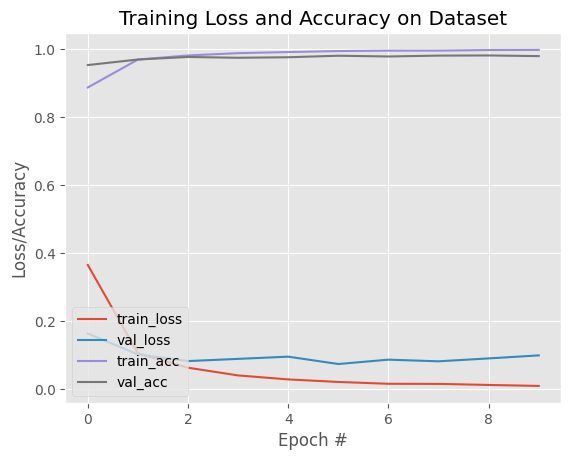

In [14]:
plt.show()

In [16]:
# set the numpy seed for better reproducibility
import numpy as np
np.random.seed(42)
# import the necessary packages
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
import argparse
import imutils
import torch
import cv2


In [17]:
# set the device we will be using to test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the KMNIST dataset and randomly grab 10 data points
testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,))
testData = Subset(testData, idxs)

# initialize the test data loader
testDataLoader = DataLoader(testData, batch_size=1)

model.eval()

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [19]:
from google.colab.patches import cv2_imshow

[INFO] ground truth label: ki, predicted label: ki


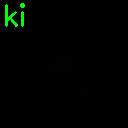

[INFO] ground truth label: ki, predicted label: ki


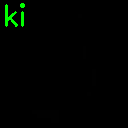

[INFO] ground truth label: ki, predicted label: ki


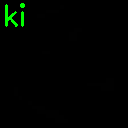

[INFO] ground truth label: ha, predicted label: ha


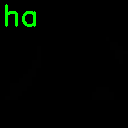

[INFO] ground truth label: tsu, predicted label: tsu


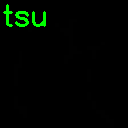

[INFO] ground truth label: ya, predicted label: ya


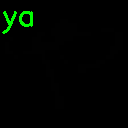

[INFO] ground truth label: tsu, predicted label: tsu


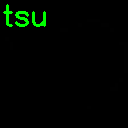

[INFO] ground truth label: na, predicted label: na


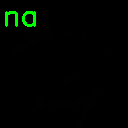

[INFO] ground truth label: ki, predicted label: ki


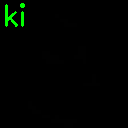

[INFO] ground truth label: tsu, predicted label: tsu


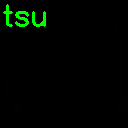

In [20]:
# switch off autograd
with torch.no_grad():
	# loop over the test set
	for (image, label) in testDataLoader:
		# grab the original image and ground truth label
		origImage = image.numpy().squeeze(axis=(0, 1))
		gtLabel = testData.dataset.classes[label.numpy()[0]]
		# send the input to the device and make predictions on it
		image = image.to(device)
		pred = model(image)
		# find the class label index with the largest corresponding
		# probability
		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = testData.dataset.classes[idx]
    # convert the image from grayscale to RGB (so we can draw on
		# it) and resize it (so we can more easily see it on our
		# screen)
		origImage = np.dstack([origImage] * 3)
		origImage = imutils.resize(origImage, width=128)
		# draw the predicted class label on it
		color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
		cv2.putText(origImage, gtLabel, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
		# display the result in terminal and show the input image
		print("[INFO] ground truth label: {}, predicted label: {}".format(gtLabel, predLabel))
		cv2_imshow(origImage)
		cv2.waitKey(0)

